In [39]:
import os
from collections import namedtuple
import pandas
import numpy
from matplotlib import pyplot as plt

DatasetFileInfo = namedtuple("DatasetFileInfo", ["path", "root_basenames", "data_frames", "suffix"])
fig_dir='/home/llr/cms/hakimi/WZ_analysis/figs/'



In [2]:
def expand_dataset_info(path):
    root_basenames = set()
    data_frames = set()
    for f in os.listdir(path):
        tmp = f.split("_")
        root_basenames.add(tmp[0])
        tmp = "_".join(tmp[1:]).split(".")
        data_frames.add(tmp[0])
        suffix = "." + ".".join(tmp[1:])

    return DatasetFileInfo(path, sorted(list(root_basenames)), sorted(list(data_frames)), suffix)


In [3]:
def is_first_in_event(event):
    return numpy.concatenate([[1], event[1:] != event[:-1]])


In [4]:
def indices_in_event(event):
    r = numpy.arange(len(event))
    t = is_first_in_event(event) * r
    w = numpy.where(t)[0]
    t[w[1:]] -= t[w[:-1]]
    return r - numpy.cumsum(t)


In [5]:
class ParquetSingleFileHandler(object):

    import pandas

    def __init__(self, file_template, data_frames):
        self._file_template = file_template
        self._data_frames = data_frames

    def keys(self):
        return self._data_frames[:]

    def __repr__(self):
        return "<ParquetSingleFileHandler for " + self._file_template + ">"

    def __contains__(self, key):
        return key in self._data_frames

    def __getitem__(self, key):
        if not key in self:
            raise ValueError("Dataset does not contain data frame named " + key + ".")
        df = pandas.read_parquet(self._file_template.format(key))
        if key == "Scalar":
            df = df.set_index("event")
        else:
            df[key] = indices_in_event(df["event"].values)
            df["event"] = df["event"].astype(int)
            df = df.set_index(["event", key])
        return df



In [6]:
class ParquetFilesHandler(object):
    def __init__(self, path):
        self._path, self._root_basenames, self._data_frames, self._suffix = expand_dataset_info(path)

    def __len__(self):
        return len(self._root_basenames)

    def keys(self):
        return self._data_frames[:]

    def __contains__(self, key):
        return key in self._data_frames

    def __getitem__(self, key):
        data_frame = None
        if hasattr(key, "__len__"):
            i, data_frame = key
        else:
            i = key
        file_template = os.path.join(self._path, self._root_basenames[i] + "_{}" + self._suffix)
        file_handler = ParquetSingleFileHandler(file_template, self._data_frames)
        if data_frame:
            return file_handler[data_frame]
        else:
            return file_handler
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]



In [7]:
def open(path):
    return ParquetFilesHandler(path)



In [8]:
def loc(df, selected_events, columns=None):
    e = df.index.values
    mask = numpy.in1d(e, selected_events)
    if columns is None:
        return df.loc[mask]
    else:
        return df.loc[mask, columns]

In [9]:
def array(data_frames, column):
    return np.concatenate([df[column] for df in data_frames])

def df_len(data_frames):
    return sum([len(df) for df in data_frames])

In [10]:
data_WZ_QCD='/data_CMS/cms/hakimi/WZ_analysis/samples/WZTo3LNu_TuneCUETP8M1_13TeV-powheg-pythia8/RunIISummer16NanoAODv6-PUMoriond17_Nano25Oct2019_102X_mcRun2_asymptotic_v7_ext1-v1/NANOAODSIM/parquet/'
data_WZ_EWK='/data_CMS/cms/hakimi/WZ_analysis/samples/WLLJJ_WToLNu_EWK_TuneCP5_13TeV_madgraph-madspin-pythia8/RunIIAutumn18NanoAODv6-Nano25Oct2019_102X_upgrade2018_realistic_v20-v1/NANOAODSIM/parquet/'


In [11]:
dataset_qcd = open(data_WZ_QCD)
dataset_ewk = open(data_WZ_EWK)

In [14]:
print(dataset_ewk._data_frames)
print(dataset_qcd._data_frames)

['CorrT1METJet', 'Electron', 'FatJet', 'FsrPhoton', 'GenDressedLepton', 'GenJet', 'GenJetAK8', 'GenPart', 'GenVisTau', 'IsoTrack', 'Jet', 'LHEPart', 'LHEPdfWeight', 'LHEReweightingWeight', 'LHEScaleWeight', 'Muon', 'OtherPV', 'PSWeight', 'Photon', 'SV', 'Scalar', 'SoftActivityJet', 'SubGenJetAK8', 'SubJet', 'Tau', 'TrigObj']
['CorrT1METJet', 'Electron', 'FatJet', 'FsrPhoton', 'GenDressedLepton', 'GenJet', 'GenJetAK8', 'GenPart', 'GenVisTau', 'IsoTrack', 'Jet', 'LHEPart', 'LHEPdfWeight', 'LHEReweightingWeight', 'LHEScaleWeight', 'Muon', 'OtherPV', 'PSWeight', 'Photon', 'SV', 'Scalar', 'SoftActivityJet', 'SubGenJetAK8', 'SubJet', 'Tau', 'TrigObj']


In [18]:
%%time
from tqdm import tqdm
file_range_qcd= range(len(dataset_qcd))
file_range_ewk= range(len(dataset_ewk))
df_qcd_elec=[dataset_qcd[i]["Electron"] for i in tqdm(file_range_qcd)]
df_qcd_jet=[dataset_qcd[i]["Jet"] for i in tqdm(file_range_qcd)]
df_ewk_elec=[dataset_ewk[i]["Electron"] for i in tqdm(file_range_ewk)]
df_ewk_jet=[dataset_ewk[i]["Jet"] for i in tqdm(file_range_ewk)]


100%|██████████| 3/3 [00:02<00:00,  1.16s/it]

CPU times: user 2min 51s, sys: 57.5 s, total: 3min 48s
Wall time: 32.6 s


In [19]:
df_ewk_elec[0].keys()

Index(['Electron_deltaEtaSC', 'Electron_dr03EcalRecHitSumEt',
       'Electron_dr03HcalDepth1TowerSumEt', 'Electron_dr03TkSumPt',
       'Electron_dr03TkSumPtHEEP', 'Electron_dxy', 'Electron_dxyErr',
       'Electron_dz', 'Electron_dzErr', 'Electron_eCorr',
       'Electron_eInvMinusPInv', 'Electron_energyErr', 'Electron_eta',
       'Electron_hoe', 'Electron_ip3d', 'Electron_jetPtRelv2',
       'Electron_jetRelIso', 'Electron_mass', 'Electron_miniPFRelIso_all',
       'Electron_miniPFRelIso_chg', 'Electron_mvaFall17V1Iso',
       'Electron_mvaFall17V1noIso', 'Electron_mvaFall17V2Iso',
       'Electron_mvaFall17V2noIso', 'Electron_pfRelIso03_all',
       'Electron_pfRelIso03_chg', 'Electron_phi', 'Electron_pt', 'Electron_r9',
       'Electron_sieie', 'Electron_sip3d', 'Electron_mvaTTH',
       'Electron_charge', 'Electron_cutBased', 'Electron_cutBased_Fall17_V1',
       'Electron_jetIdx', 'Electron_pdgId', 'Electron_photonIdx',
       'Electron_tightCharge', 'Electron_vidNestedWPBitmap

In [20]:
df_ewk_jet[0].keys()

Index(['Jet_area', 'Jet_btagCMVA', 'Jet_btagCSVV2', 'Jet_btagDeepB',
       'Jet_btagDeepC', 'Jet_btagDeepFlavB', 'Jet_btagDeepFlavC', 'Jet_chEmEF',
       'Jet_chHEF', 'Jet_eta', 'Jet_jercCHF', 'Jet_jercCHPUF', 'Jet_mass',
       'Jet_muEF', 'Jet_muonSubtrFactor', 'Jet_neEmEF', 'Jet_neHEF', 'Jet_phi',
       'Jet_pt', 'Jet_qgl', 'Jet_rawFactor', 'Jet_bRegCorr', 'Jet_bRegRes',
       'Jet_electronIdx1', 'Jet_electronIdx2', 'Jet_jetId', 'Jet_muonIdx1',
       'Jet_muonIdx2', 'Jet_nConstituents', 'Jet_nElectrons', 'Jet_nMuons',
       'Jet_puId', 'Jet_genJetIdx', 'Jet_hadronFlavour', 'Jet_partonFlavour',
       'Jet_cleanmask'],
      dtype='object')

In [29]:
%%time
print("Number of ewk electrons: "+ str(df_len(df_ewk_elec)))
print("Number of qcd electrons: "+ str(df_len(df_qcd_elec)))

Number of ewk electrons: 1374480
Number of qcd electrons: 14096997
CPU times: user 445 µs, sys: 150 µs, total: 595 µs
Wall time: 554 µs


CPU times: user 11.1 s, sys: 967 ms, total: 12 s
Wall time: 11.4 s


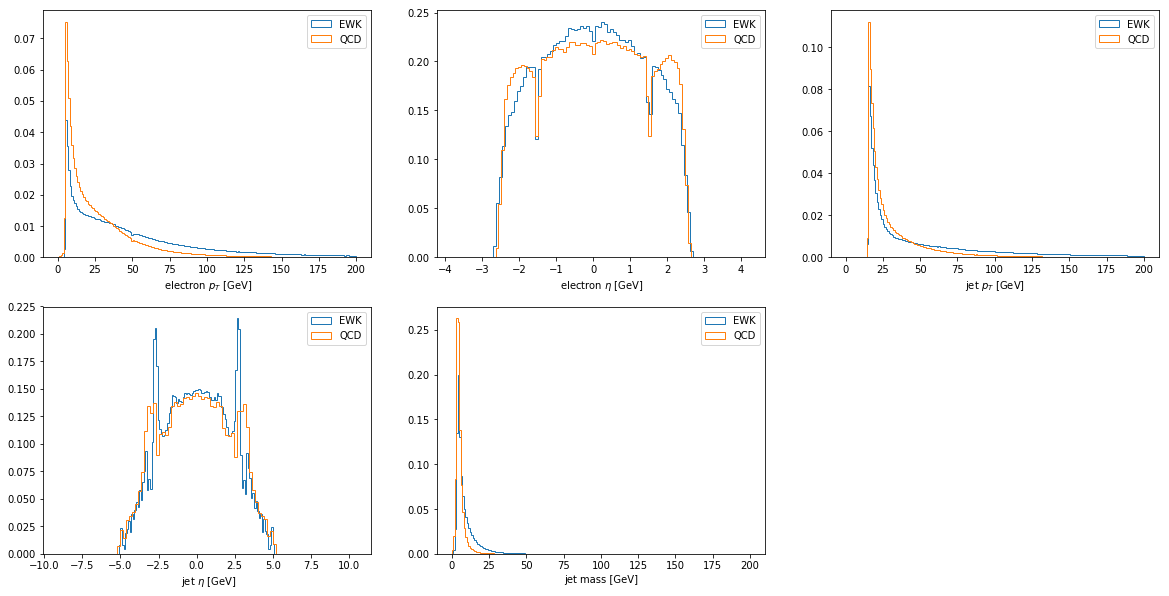

In [40]:
%%time
bins = numpy.linspace(0, 200, 200)


plt.figure(figsize=(20,10))
plt.subplot(2, 3, 1)
plt.hist(array(df_ewk_elec, "Electron_pt"), bins=bins, label='EWK', histtype='step', density=True)
plt.hist(array(df_qcd_elec, "Electron_pt"), bins=bins, label= 'QCD', histtype='step', density=True)
plt.legend()
plt.xlabel(r" electron $p_T$ [GeV]")

plt.subplot(2, 3, 2)
plt.hist(array(df_ewk_elec, "Electron_eta"), bins=100, label='EWK', histtype='step', density=True)
plt.hist(array(df_qcd_elec, "Electron_eta"), bins=100, label= 'QCD', histtype='step', density=True)
plt.legend()
plt.xlabel(r" electron $\eta$ [GeV]")

#plt.show()
plt.subplot(2, 3, 3)
plt.hist(array(df_ewk_jet, "Jet_pt"), bins=bins, label='EWK', histtype='step', density=True)
plt.hist(array(df_qcd_jet, "Jet_pt"), bins=bins, label= 'QCD', histtype='step', density=True)
plt.xlabel(r"jet $p_T$ [GeV]")
plt.legend()

plt.subplot(2, 3, 4)
plt.hist(array(df_ewk_jet, "Jet_eta"), bins=100, label='EWK', histtype='step', density=True)
plt.hist(array(df_qcd_jet, "Jet_eta"), bins=100, label= 'QCD', histtype='step', density=True)
plt.legend()
plt.xlabel(r" jet $\eta$ [GeV]")

plt.subplot(2, 3, 5)
plt.hist(array(df_ewk_jet, "Jet_mass"), bins=bins, label='EWK', histtype='step', density=True)
plt.hist(array(df_qcd_jet, "Jet_mass"), bins=bins, label= 'QCD', histtype='step', density=True)
plt.xlabel(r"jet mass [GeV]")
plt.legend()

plt.savefig(fig_dir+'distrib.png')
